<a href="https://colab.research.google.com/github/ShuaimingJing/XAI_assignment2/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #3 Interpretable ML
### Name: Shuaiming Jing

### Referenced material: https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/interpretable-ml-example-notebooks/regression-interpretability.ipynb#scrollTo=qgAR7EIlDbOR

In [1]:
! pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm
import seaborn as sns
from google.colab import drive
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import Log
from statsmodels.tools import add_constant
from pygam import LinearGAM, GammaGAM, s
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve

drive.mount('/content/drive')

Mounted at /content/drive


# Feature Engineering

In [3]:
file_path = '/content/drive/My Drive/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
unique_values = df['Churn'].unique()
print(unique_values)

['No' 'Yes']


In [5]:
file_path = '/content/drive/My Drive/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == 'No' else 1)  # 0 for staying, 1 for churning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0) # handle nah values

df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
# df['Churn'] = df['Churn'].replace({'1': 1, '0': 0})
df['Churn'] = df['Churn'].astype(float)
df_numberical_columns = df[['SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]

# Dummy the non-numerical columns
non_numerical_columns = df.drop(columns=['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'customerID', 'Churn'])
df_dummies = pd.get_dummies(non_numerical_columns, drop_first=True)

df_new = df_numberical_columns.merge(df_dummies, left_index=True, right_index=True)
X = df_new.drop(columns='Churn')
y = df_new['Churn']
# Create a function to convert True/False values into 1/0
def replace_boolean_with_binary(df):
    # Create a list of columns that contain True/False values
    boolean_columns = [col for col in df.columns if df[col].dtype == bool]
    # Define the replacement dictionary
    replacement_dict = {True: 1, False: 0}
    # Loop through the boolean columns and apply the replacement
    for col in boolean_columns:
        df[col] = df[col].replace(replacement_dict)
replace_boolean_with_binary(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_columns = X_train.columns


In [6]:
y.value_counts()

,count
Churn,
0.0,5174
1.0,1869


# **Linear** **Regression**

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.13413467815056088
R-squared: 0.3108806091343702


In [8]:
intercept = model.intercept_
coefficients = model.coef_

# Display the intercept and coefficients
print(f"Intercept (β0): {intercept}")
print("Coefficients (β1, β2, ... βn):")
for feature, coef in zip(X_train.columns, coefficients):
    print(f"{feature}: {coef}")

# Construct the equation
equation = f"Predicted y = {intercept:.3f} "
for feature, coef in zip(X_train.columns, coefficients):
    equation += f"+ ({coef:.3f}) * {feature} "

print("\nModel Equation:")
print(equation)

Intercept (β0): 0.5233370600530669
Coefficients (β1, β2, ... βn):
SeniorCitizen: 0.037677242704826544
tenure: -0.001927322196165571
MonthlyCharges: -0.0044777761085142784
TotalCharges: -4.166020809532729e-05
gender_Male: -0.008574428008310682
Partner_Yes: 0.007008014835057729
Dependents_Yes: -0.023306672494586466
PhoneService_Yes: 0.02687949604635079
MultipleLines_No phone service: -0.026879496046350763
MultipleLines_Yes: 0.0713069922532439
InternetService_Fiber optic: 0.281640928964822
InternetService_No: -0.036515558727124725
OnlineSecurity_No internet service: -0.03651555872712476
OnlineSecurity_Yes: -0.03513129262953839
OnlineBackup_No internet service: -0.03651555872712499
OnlineBackup_Yes: -0.000998876979626676
DeviceProtection_No internet service: -0.03651555872712499
DeviceProtection_Yes: 0.021788222924990143
TechSupport_No internet service: -0.03651555872712486
TechSupport_Yes: -0.026922451646948155
StreamingTV_No internet service: -0.03651555872712484
StreamingTV_Yes: 0.08825

**Model explaination:** (0.523) is the intercept: It represents the predicted value of y when all features are set to zero. It serves as the baseline value of the prediction.

Other coefficients  represent the amount of change in the predicted value of y for a one-unit change in the corresponding feature, assuming all other features are held constant.

There exists a limitation of linear regression model: I use dummy variables when doing the feature engineering, but this will lead to the issue. Take the feature 'TechSupport' as an example. After using dummy, it will become two variables 'TechSupport_Yes' and 'TechSupport_No', and these two features depend on each other. If 'TechSupport_Yes' is 1, then 'TechSupport_No' should be 0 according to common sense. But this contradicts to the assumption of linear model that the features should be independent between each other.

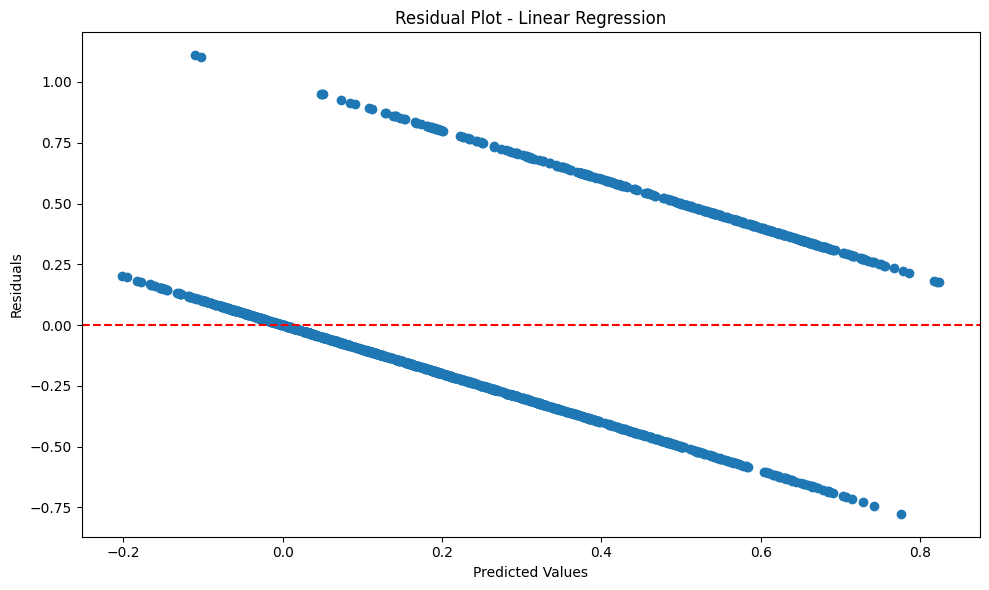

In [9]:
# Residual Plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, y_pred, 'Linear Regression')

The residuals are not randomly scattered around the horizontal line, suggesting that the assumptions of linearity and homoscedasticity are not met for linear regression

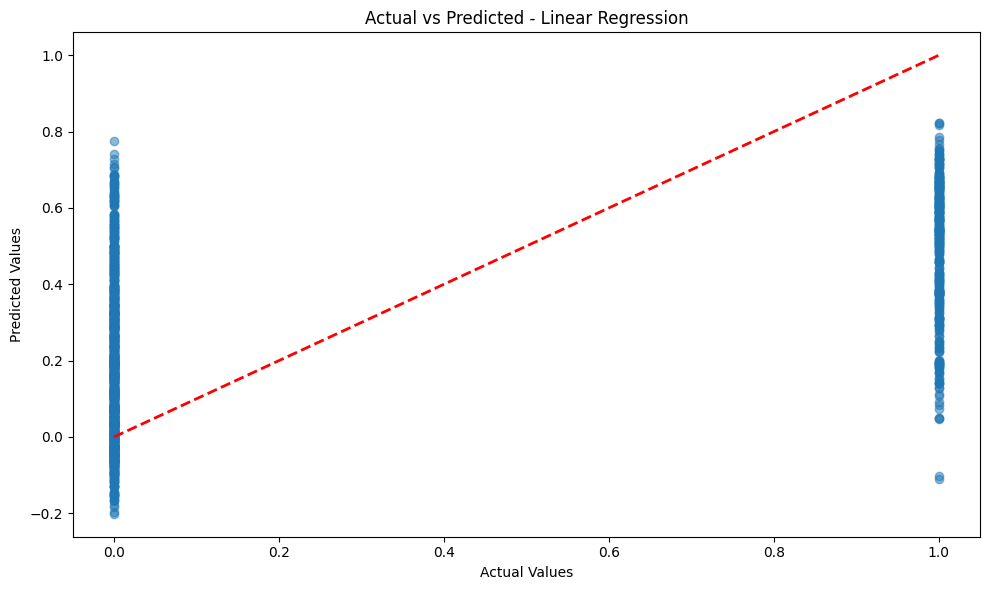

In [10]:

# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, y_pred, 'Linear Regression')


# **Logistic Regression**

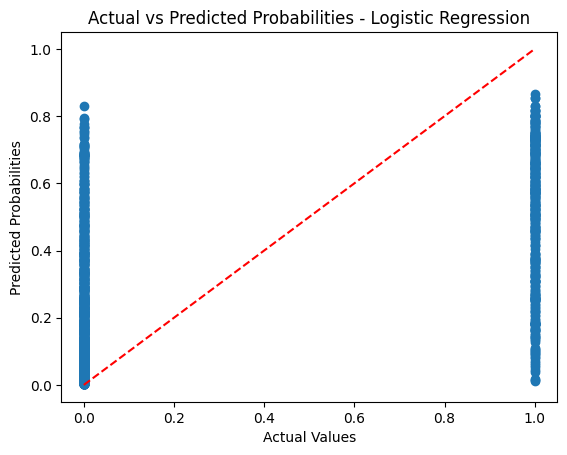

In [17]:
model = LogisticRegression(max_iter=1000)

# Fit the model on the training data
model.fit(X_train, y_train)

# Use .predict_proba() to get probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of class '1' (churn)



# Plot Actual vs. Predicted Probabilities
plt.scatter(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Probabilities')
plt.title('Actual vs Predicted Probabilities - Logistic Regression')
plt.show()

In [19]:
intercept = model.intercept_[0]
coefficients = model.coef_[0]

# Get the feature names
feature_names = feature_columns

# Print the equation for logistic regression
print(f"Logistic Regression Equation: log-odds(y) = {intercept:.4f}", end='')

for i, coef in enumerate(coefficients):
    print(f" + ({coef:.4f}) * {feature_names[i]}", end='')

# To predict probability:
print("\n\nPredicted probability is given by the sigmoid function:")
print("y_pred = 1 / (1 + exp(-log-odds(y)))")

Logistic Regression Equation: log-odds(y) = -0.1777 + (0.2237) * SeniorCitizen + (-0.0618) * tenure + (0.0048) * MonthlyCharges + (0.0003) * TotalCharges + (-0.0457) * gender_Male + (0.1049) * Partner_Yes + (-0.1546) * Dependents_Yes + (-0.4486) * PhoneService_Yes + (0.2733) * MultipleLines_No phone service + (0.2108) * MultipleLines_Yes + (0.5501) * InternetService_Fiber optic + (-0.1154) * InternetService_No + (-0.1154) * OnlineSecurity_No internet service + (-0.5889) * OnlineSecurity_Yes + (-0.1154) * OnlineBackup_No internet service + (-0.2517) * OnlineBackup_Yes + (-0.1154) * DeviceProtection_No internet service + (-0.0884) * DeviceProtection_Yes + (-0.1154) * TechSupport_No internet service + (-0.5373) * TechSupport_Yes + (-0.1154) * StreamingTV_No internet service + (0.1427) * StreamingTV_Yes + (-0.1154) * StreamingMovies_No internet service + (0.2493) * StreamingMovies_Yes + (-0.3901) * Contract_One year + (-0.6954) * Contract_Two year + (0.4099) * PaperlessBilling_Yes + (-0.12

**Model Explanation:** The log-odds represent the logarithm of the odds that the target variable y (churn) equals 1. The intercept (-0.1777) means the log-odds of churn when all features are zero (i.e., for a baseline customer). It serves as the starting point of the log-odds calculation.

Each coefficient in the equation represents the log-odds change associated with a one-unit change in the corresponding feature, assuming all other features are held constant.

It has the same limitaion as the linear regression due to non-linearity for each feature.

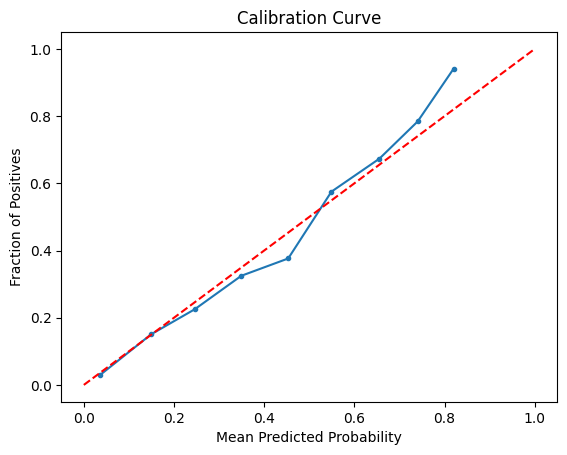

In [12]:
# Calibration plot - Helps assess how well the predicted probabilities match the actual likelihood of an event.
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Diagonal line
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.show()

AUC-ROC: 0.86


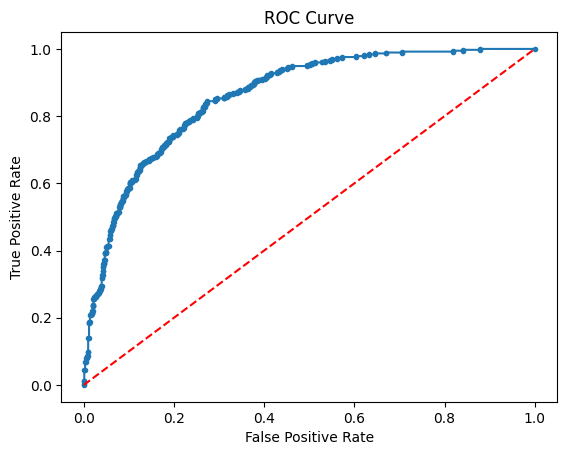

In [13]:
# AUROC curve
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [14]:
# Check sample size and events per predictor
n_obs = X_train.shape[0]
n_preds = X_train.shape[1]
n_events = sum(y_train)

print(f"Sample size: {n_obs}")
print(f"Number of predictors: {n_preds}")
print(f"Number of events: {n_events}")

# Check for at least 10 events per predictor
if n_events / n_preds < 10:
    print("Warning: Insufficient events per predictor. Consider reducing the number of predictors.")


Sample size: 5634
Number of predictors: 30
Number of events: 1496.0


# **Generalized Additive Model**

In [15]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)


# Initilize GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) +
                s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) +
                s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29))
# Find best smoothing parameters for each spline term
gam.gridsearch(X_train, y_train)

# Fit the model
gam.fit(X_train, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:01:09 Time:  0:01:09


GAM MSE: 0.1304, R^2: 0.3301
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     43.1012
Link Function:                     IdentityLink Log Likelihood:                                -14458.9559
Number of Samples:                         5634 AIC:                                            29006.1141
                                                AICc:                                           29006.8259
                                                GCV:                                                0.1382
                                                Scale:                                              0.1363
                                                Pseudo R-Squared:                                   0.3065
Feature 

<ipython-input-15-1f1f9d49e144>:24: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [21]:
intercept = gam.coef_[0]
print(f"Intercept: {intercept:.4f}")

Intercept: -0.0243


In [22]:
coefficients = gam.coef_
print(f"All coefficients (including intercept): {coefficients}")

All coefficients (including intercept): [-2.42994648e-02 -2.18644788e-02 -1.94294928e-02 -1.69945068e-02
 -1.45595209e-02 -1.21245349e-02 -9.68954901e-03 -7.25456312e-03
 -4.81957725e-03 -2.38459140e-03  5.03944400e-05  2.48538027e-03
  4.92036610e-03  7.35535194e-03  9.79033778e-03  1.22253236e-02
  1.46603095e-02  1.70952954e-02  1.95302813e-02  2.19652672e-02
  2.73920228e-01  1.06784164e-01 -4.66583173e-02 -1.10724389e-01
 -1.08349769e-01 -1.03332332e-01 -1.02280727e-01 -1.01513676e-01
 -9.44716949e-02 -6.72310639e-02 -3.22712676e-02 -1.69796995e-02
 -4.45258630e-03  1.48709726e-02  2.73436554e-02  2.53741873e-02
  4.40553718e-02  8.52151575e-02  9.47258850e-02  9.26418587e-02
  3.66820936e-01  2.95362506e-01  2.24989780e-01  1.74762121e-01
  1.42133109e-01  1.01796024e-01  4.97038441e-02  7.68899211e-03
 -2.41305639e-02 -5.14898542e-02 -6.44756791e-02 -7.87954368e-02
 -1.04551011e-01 -1.52279647e-01 -1.69873063e-01 -1.54516205e-01
 -1.57315749e-01 -1.59496158e-01 -1.44101240e-01 -

##Model Explanation:**
The first coefficient is the intercept.
The other coefficients control the shapes of the smooth functions (splines) for each feature, which describe the non-linear relationship between the features and the target.

These coefficients are best interpreted through partial dependence plots, which show how the predicted target changes as the feature values change.
GAM coefficients don't have the same direct interpretation as in a linear regression; instead, they describe the shapes of the smooth functions fitted to each feature.


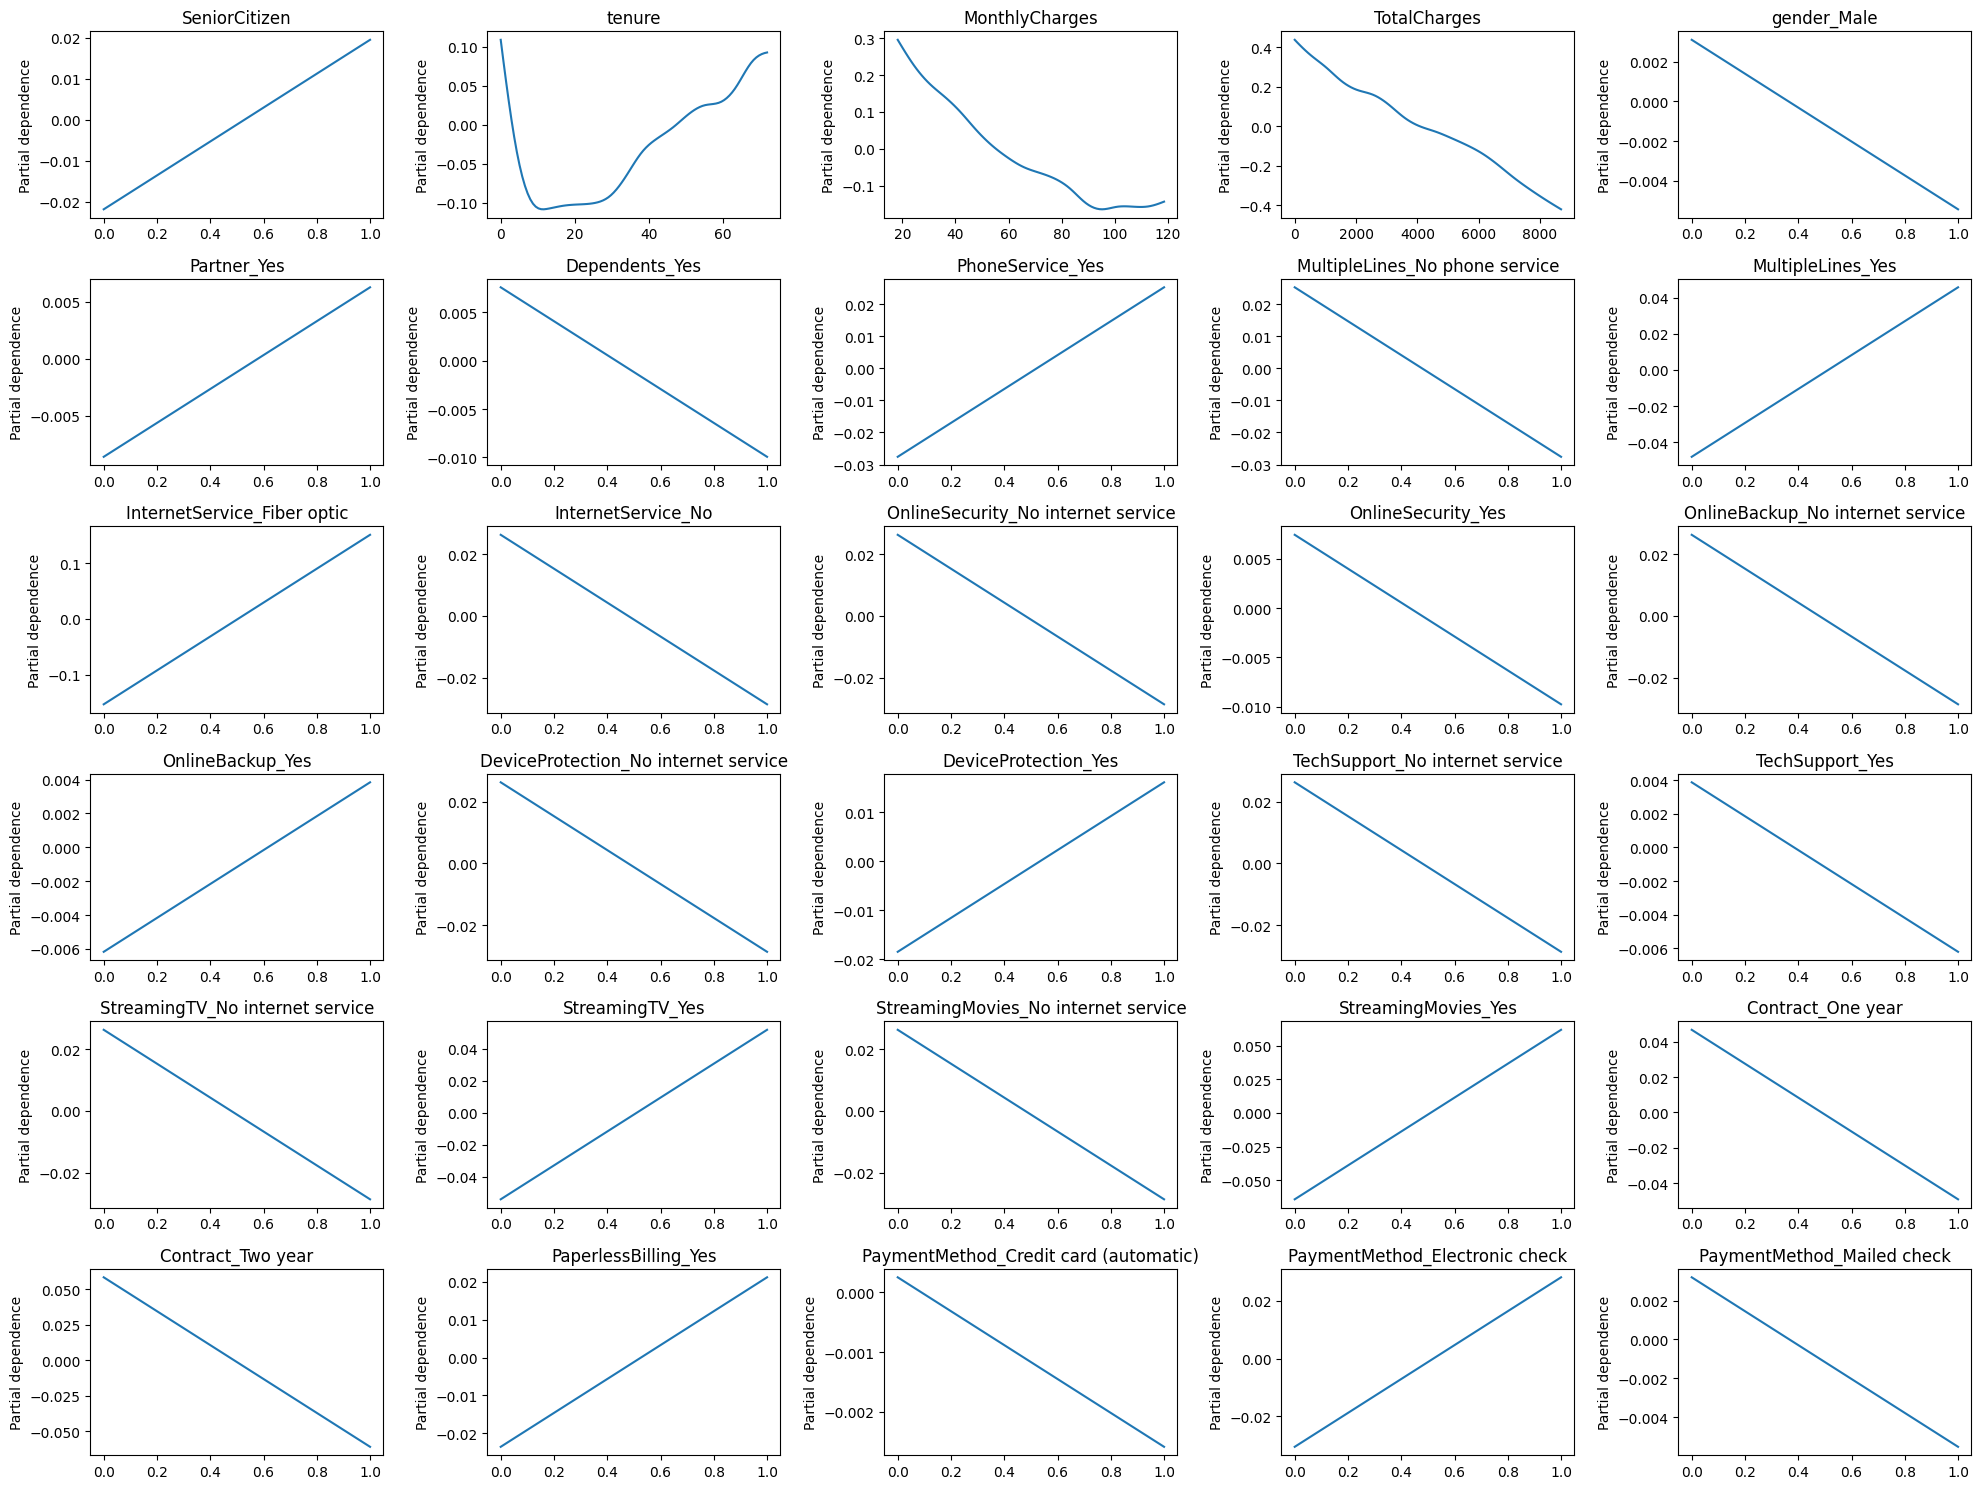

In [16]:
# Plots the partial dependence of each feature, showing the effect of each feature on the predicted outcome while holding other features constant.
plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(6, 5, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(feature_columns[i])
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()

# Non-coding Part (Discussion)

Linear regression model has high interpretability. Each coefficient directly shows how each feature influence the output and it can be trained quickly with less computational costs. but it violates the assumption of linearity between each feature, and can generate probabilities outside the 0-1 range, which doesn't make sense for binary classification tasks.

Logistic regression is specifically designed for binary classification problems like predicting whether a customer will churn or not. It estimates the probability that a given input belongs to a certain class, using the sigmoid function to map predictions to a probability between 0 and 1. Coefficients can be easily interpreted in terms of odds ratios, making it easy to understand the influence of each feature on the likelihood of churn. (Slightly lower interpretability than linear regression) Logistic regression assumes a linear relationship between the features and the log-odds of the target variable. If the relationships are non-linear, it may not perform well. It may struggle with more complex relationships that require non-linear decision boundaries.

GAM provides insights into the specific non-linear effects of each feature, which may help the company understand more complex patterns in churn behavior.
However, GAM is more complex and requires more computational resources, and most modifications of the linear model make the model less interpretable so it can be harder to explain to non-technical stakeholders.

**Recommendation:** If the company is looking for a straightforward, interpretable, and relatively fast model, logistic regression is a better choice. Logistic regression provides a probabilistic output that can be easily interpreted by business stakeholders. It also allows the company to prioritize features based on the coefficients to understand which factors contribute the most to churn.

If the company is looking for a model with better performance, regradless the interpretability and computational costs, GAM is a better choice. GAM provides insights into the specific non-linear effects of each feature, which may help the company understand more complex patterns in churn behavior, leading to better performance.